# Read In, Clean, And Split The Data

In [1]:
# Read in data and split into training and test set

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

# Prep Data For Modeling

In [2]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [4]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [5]:
# What do these sequences look like?
X_train_seq[0]

[26, 247, 6, 3811, 72, 873, 6, 45, 47, 1677, 34, 233, 1678, 79, 284, 36, 6, 76]

In [6]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [7]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   26,
        247,    6, 3811,   72,  873,    6,   45,   47, 1677,   34,  233,
       1678,   79,  284,   36,    6,   76], dtype=int32)

# Build Model

In [8]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [9]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          255200    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 264,609
Trainable params: 264,609
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [11]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 7s 31ms/step - loss: 0.4326 - accuracy: 0.8788 - precision_m: 0.1112 - recall_m: 0.0879 - val_loss: 0.0787 - val_accuracy: 0.9812 - val_precision_m: 1.0000 - val_recall_m: 0.8686
Epoch 2/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0427 - accuracy: 0.9888 - precision_m: 0.9641 - recall_m: 0.9168 - val_loss: 0.0615 - val_accuracy: 0.9874 - val_precision_m: 1.0000 - val_recall_m: 0.9137
Epoch 3/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0095 - accuracy: 0.9974 - precision_m: 0.9958 - recall_m: 0.9826 - val_loss: 0.0638 - val_accuracy: 0.9865 - val_precision_m: 0.9745 - val_recall_m: 0.9241
Epoch 4/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0034 - accuracy: 0.9991 - precision_m: 0.9858 - recall_m: 0.9814 - val_loss: 0.0651 - val_accuracy: 0.9865 - val_precision_m: 0.9881 - val_recall_m: 0.9194
Epoch 5/10
140/140 [==============================] - 4s 26ms/step -

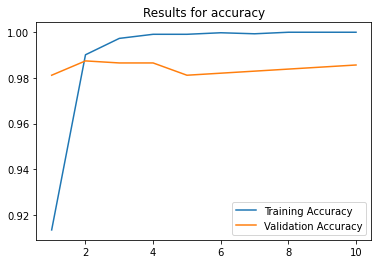

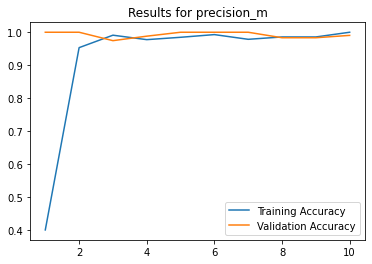

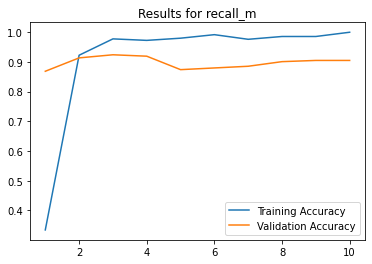

In [12]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()